# A simple implementation of the 2D Radon Transform (2D RT)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# First, some useful functions

In [2]:
def show_imvals(ax, img):
    '''for nice image plotting with intensity labels'''
    imnorm = img - np.min(img)
    if np.std(imnorm)>0:
        imnorm = imnorm / np.max(imnorm)
    Nk, Nk = imnorm.shape
    ax.imshow(imnorm, cmap='gray', vmin=-1,vmax=1,extent=(0,Nk,0,Nk))
    ax.set_xticks(range(Nk+1))
    ax.set_yticks(range(Nk+1))
    ax.grid(which='both',color='k')
    
    # label vals
    fsz = 12*3/Nk
    for i in range(Nk):
        for j in range(Nk):
            ax.text(i+0.5,j+0.5,img[::-1, :][j,i],fontsize=fsz,  ha='center', va='center')
           

In [3]:
class Phantom2D:
    '''Class to handle input phantom and corresponding params. '''
    def __init__(self, M, dtype=np.uint8):
        self.M = M
        self.Ny, self.Nx = self.M.shape

# Before the full 2D RT, individual line profiles.

In [4]:
def raytrace(phantom, phi, xi, dl=0.1, plot=False):
    '''a function to retrieve a single line integral through a 2D matrix'''
    # initialize rotated P0, Pf (start and end points for ray)
    rotation_matrix = np.array([[np.cos(phi), -np.sin(phi)],
                                [np.sin(phi), np.cos(phi)]])
    P0 = rotation_matrix@np.array([xi, phantom.Nx])
    Pf = rotation_matrix@np.array([xi, -phantom.Nx])
    Px, Py = np.array([P0,Pf]).T + [phantom.Nx/2,phantom.Nx/2]
    P0, Pf = np.array([Px,Py]).T # shifted to phantom indexing (0->Nx, 0->Ny)
    
    # get evaluation points for line profile 
    points = []
    for n in range(-int(2*phantom.Nx/dl),int(2*phantom.Nx/dl)):
        point = P0 + n*dl*np.array([np.cos(phi+np.pi/2),np.sin(phi+np.pi/2)])
        if point[0]>0 and point[0]<phantom.Nx and point[1]>0 and point[1]<phantom.Ny:
            points.append(point)

    # calculate the line profile
    values = []
    for point in points:
        px, py = point
        ix, iy = int(px), int(phantom.Ny-py)
        values.append(phantom.M[iy,ix])
    
    if plot:
        # create plot to visualize
        fig,ax=plt.subplots(1,2, dpi=100, figsize=[6,3], facecolor='w')
        
        ax[0].set_title('object')
        ax[1].set_title('line profile')

        ax[0].plot(Px, Py, 'ro-')
        show_imvals(ax[0] ,phantom.M)

        ax[1].plot(dl*np.arange(len(values)), values, 'r-')
        ax[1].set_ylim(np.min(phantom.M)-0.2,np.max(phantom.M)+0.2)
        #plt.savefig('examples/line_profile.png')
        plt.show()
    
    return np.sum(values)*dl # line integral

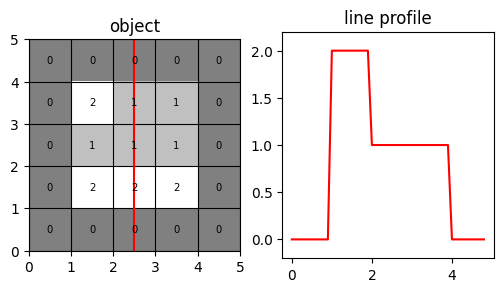

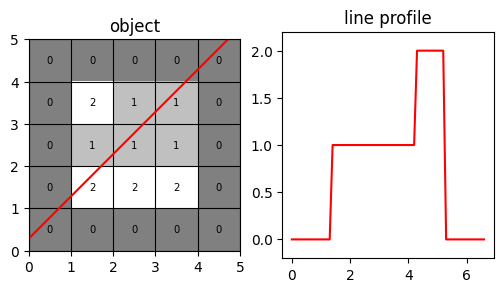

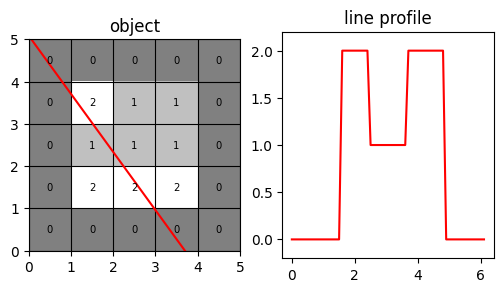

5.4

In [5]:
# test a few line profiles
phantom = Phantom2D(np.array([[0,0,0,0,0],
                           [0,2,1,1,0],
                           [0,1,1,1,0],
                           [0,2,2,2,0],
                           [0,0,0,0,0]]))

raytrace(phantom,   0*np.pi,   0, plot=True)
raytrace(phantom, .75*np.pi, 0.2, plot=True)
raytrace(phantom, 1.2*np.pi, 0.5, plot=True)

# Use many line integrals to get the 2D RT $p(\xi,\phi)$

In [10]:
def RT2D(phantom, Nxi=20, Nphi=20, plot_sino=True, get_sino=False):
    '''a function to calculate and show the 2D Radon Transform of a 2D matrix'''
    # make a sinogram
    N = np.min([phantom.Nx, phantom.Ny])
    xi_vals = np.linspace(-N/2+.1, N/2-.1, Nxi)  # bounds must be within +-N/2 !!
    phi_vals = np.linspace(0, 2*np.pi, Nphi)
    sino = np.zeros([len(phi_vals), len(xi_vals)])
    for i,xi in enumerate(xi_vals):
        for j,phi in enumerate(phi_vals):
            sino[j,i] = raytrace(phantom, phi, xi)
    if plot_sino:
        fig,ax=plt.subplots(1, 2, figsize=[6,3], dpi=100, facecolor='w')
        ax[0].imshow(phantom.M)
        ax[0].set_xlabel('$x$')
        ax[0].set_ylabel('$y$')
        ax[0].set_title('object $f(x,y)$')
        ax[1].imshow(sino, 
                  extent=(min(xi_vals),max(xi_vals), min(phi_vals),max(phi_vals)), 
                  aspect=(max(xi_vals)-min(xi_vals))/(max(phi_vals)-min(phi_vals)))
        ax[1].set_xlabel('$\\xi$')
        ax[1].set_ylabel('$\phi$')
        ax[1].set_title('sinogram $p(\\xi,\phi)$')
        fig.tight_layout()
        #plt.savefig('examples/sino.png')
        plt.show()
    if get_sino:
        return sino

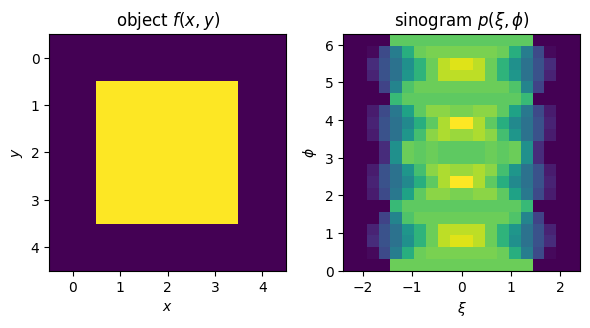

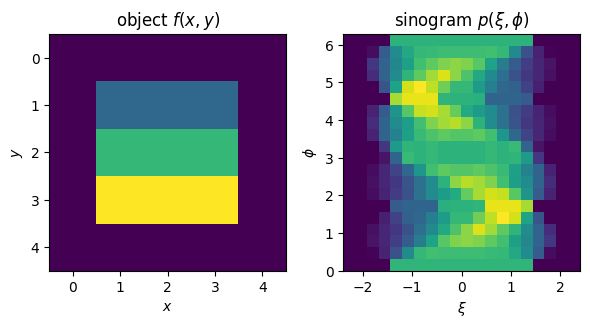

CPU times: user 1.17 s, sys: 530 ms, total: 1.7 s
Wall time: 1.03 s


In [7]:
%%time 

square_uniform = Phantom2D(np.array([[0,0,0,0,0],
                                   [0,1,1,1,0],
                                   [0,1,1,1,0],
                                   [0,1,1,1,0],
                                   [0,0,0,0,0]]))

square_nonuni = Phantom2D(np.array([[0,0,0,0,0],
                                   [0,1,1,1,0],
                                   [0,2,2,2,0],
                                   [0,3,3,3,0],
                                   [0,0,0,0,0]]))

for square in [square_uniform, square_nonuni]:
    RT2D(square)

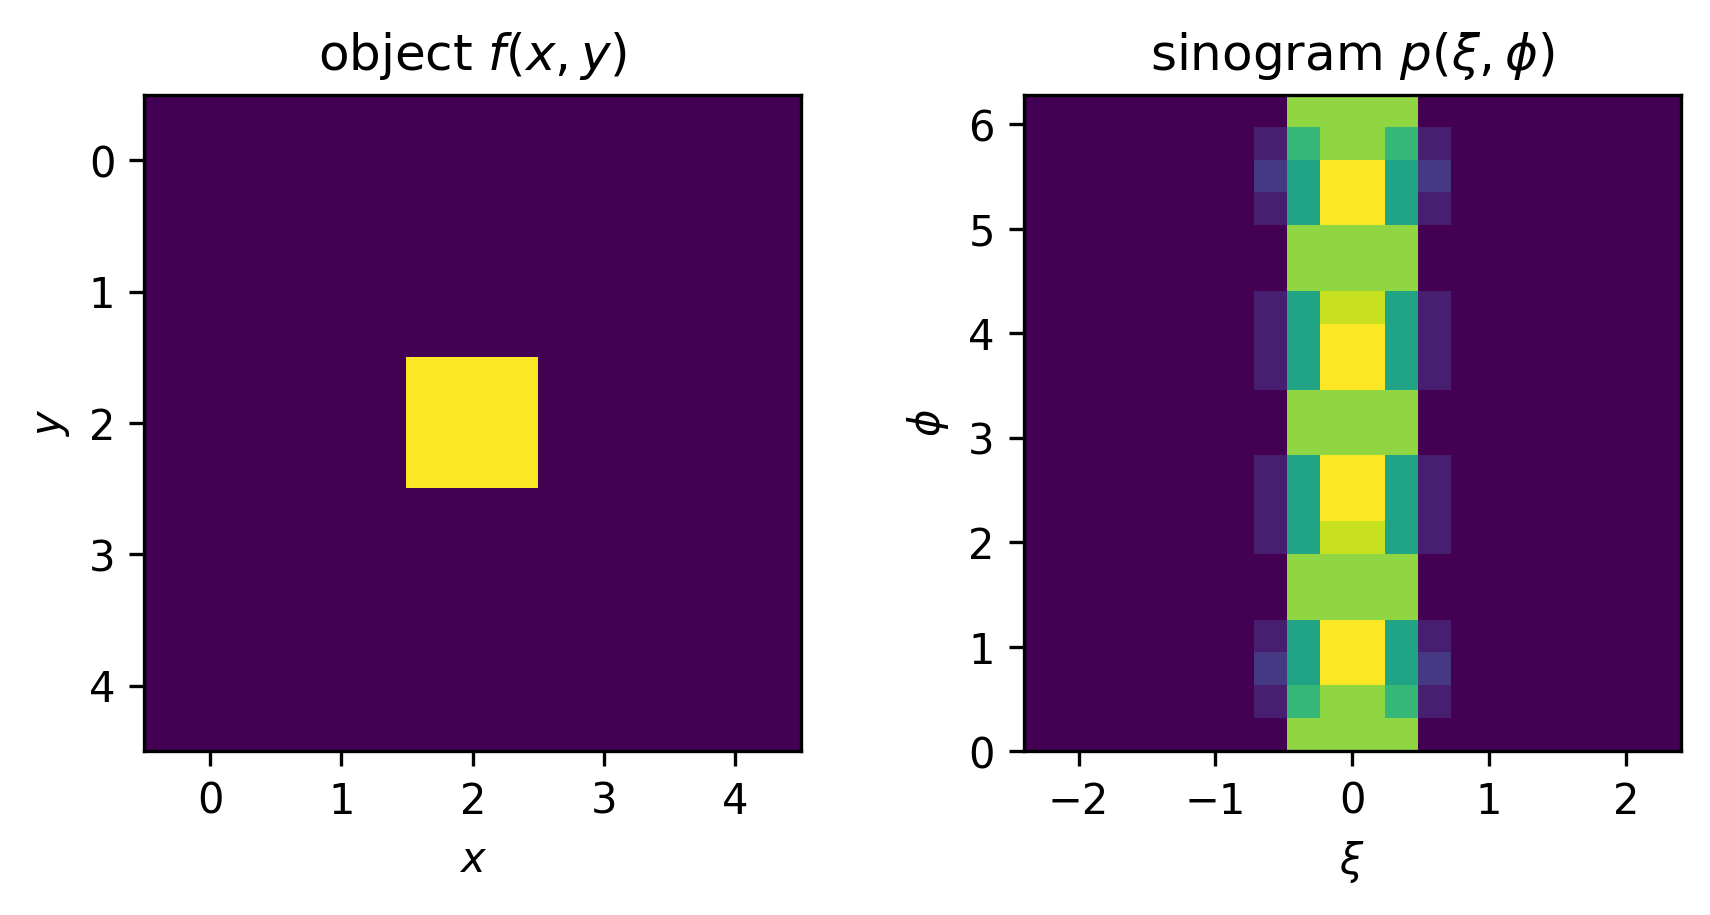

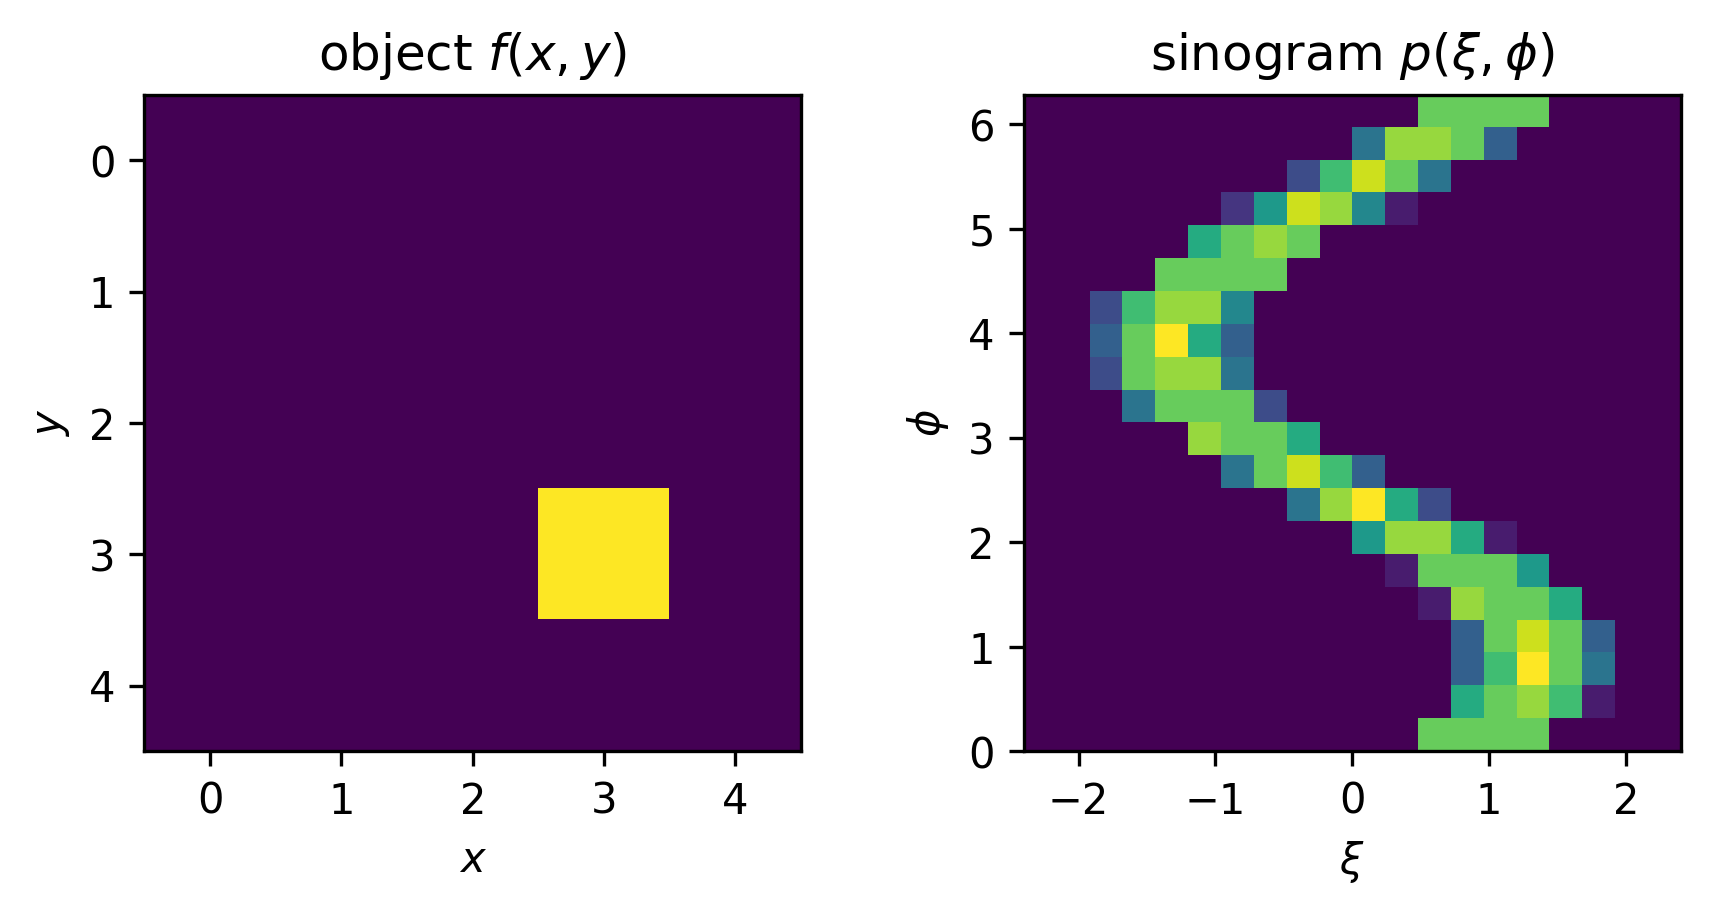

CPU times: user 1.46 s, sys: 455 ms, total: 1.91 s
Wall time: 1.39 s


In [11]:
%%time

point_center = Phantom2D(np.array([[0,0,0,0,0],
                                  [0,0,0,0,0],
                                  [0,0,1,0,0],
                                  [0,0,0,0,0],
                                  [0,0,0,0,0]]))
point_skew   = Phantom2D(np.array([[0,0,0,0,0],
                                  [0,0,0,0,0],
                                  [0,0,0,0,0],
                                  [0,0,0,1,0],
                                  [0,0,0,0,0]]))

for point in [point_center, point_skew]:
    RT2D(point)

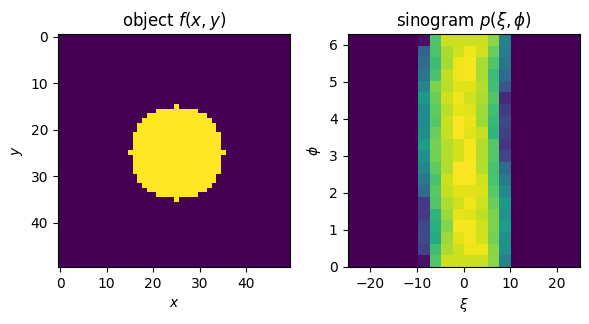

CPU times: user 3.6 s, sys: 241 ms, total: 3.84 s
Wall time: 3.59 s


In [9]:
%%time

N = 50
circle = np.zeros([N,N])
radius = 10
for i in range(N):
    for j in range(N):
        if np.sqrt((i-N/2)**2 + (j-N/2)**2)<=radius:
            circle[i,j]=1
            
circle_phantom = Phantom2D(circle)
RT2D(circle_phantom)